In [1]:
import os
import pandas as pd
import numpy as np
import json

In [2]:
meta_df = pd.read_csv('MEISD/MEISD_text.csv')

In [3]:
meta_df.shape

(20017, 15)

In [4]:
meta_df.head(3)

,TV Series,Utterances,dialog_ids,uttr_ids,seasons,episodes,start_times,end_times,sentiment,emotion,intensity,emotion2,intensity2,emotion3,intensity3
0,GA,look around you,1,0,1,1,00:02:27:589,00:02:28:567,neutral,neutral,NaN,NaN,NaN,NaN,NaN
1,GA,say hello to your competition,1,1,1,1,00:02:28:910,00:02:30:513,neutral,neutral,NaN,NaN,NaN,NaN,NaN
2,GA,eight of you will switch to an easier specialty,1,2,1,1,00:02:31:387,00:02:34:060,neutral,neutral,NaN,NaN,NaN,NaN,NaN


In [5]:
# For the multilabel classification we use:
columns = ['Utterances', 'sentiment', 'emotion', 'intensity', 'emotion2', 'intensity2', 'emotion3', 'intensity3']
meta_dfs = meta_df[columns].copy()

In [6]:
# Define emotion and sentiment mappings
emotion_map = {
    'neutral': 0,
    'acceptance': 1,
    'disgust': 2,
    'surprise': 3,
    'joy': 4,
    'sadness': 5,
    'anger': 6,
    'like': 7,
    'fear': 8
}

sentiment_map = {  
    'positive': 1,
    'negative': 0,
    'neutral': 2
}

In [7]:
meta_dfs.loc[:, 'sentiment'] = pd.to_numeric(meta_dfs['sentiment'].map(sentiment_map).fillna(2).astype(int))  # Use 2 as a default for unknown
meta_dfs.loc[:, 'emotion'] = pd.to_numeric(meta_dfs['emotion'].map(emotion_map))
meta_dfs.loc[:, 'emotion2'] = pd.to_numeric(meta_dfs['emotion2'].map(emotion_map))
meta_dfs.loc[:, 'emotion3'] = pd.to_numeric(meta_dfs['emotion3'].map(emotion_map))

# Convert intensity columns to numeric
meta_dfs.loc[:, 'intensity'] = pd.to_numeric(meta_dfs['intensity'], errors='coerce')
meta_dfs.loc[:, 'intensity2'] = pd.to_numeric(meta_dfs['intensity2'], errors='coerce')
meta_dfs.loc[:, 'intensity3'] = pd.to_numeric(meta_dfs['intensity3'], errors='coerce')

In [8]:
# Create new columns
# 1. Combined emotions column (as a list of int)
meta_dfs['combined_emotions'] = meta_dfs[['emotion', 'emotion2', 'emotion3']].apply(lambda x: x.dropna().unique().astype(int).tolist(), axis=1)

# 2. Combined intensity column (as a list of int)
meta_dfs['combined_intensities'] = meta_dfs[['intensity', 'intensity2', 'intensity3']].apply(lambda x: x.dropna().unique().astype(int).tolist(), axis=1)

In [9]:
columns = ['Utterances', 'sentiment', 'combined_emotions', 'combined_intensities']
multi_column_MEISD = meta_dfs[columns]

In [10]:
multi_column_MEISD.head()

,Utterances,sentiment,combined_emotions,combined_intensities
0,look around you,2,[0],[]
1,say hello to your competition,2,[0],[]
2,eight of you will switch to an easier specialty,2,[0],[]
3,five of you will crack under the pressure,2,[0],[]
4,two of you will be asked to leave,2,[0],[]


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Create separate binary vectors for sentiment, emotions, and intensity

mlb_emotion = MultiLabelBinarizer()
emotion_binarized = mlb_emotion.fit_transform(meta_dfs['combined_emotions'])
emotion_df = pd.DataFrame(emotion_binarized)
emotion_df.columns = [f'emotion_{i + 1}' for i in range(emotion_df.shape[1])]

mlb_intensity = MultiLabelBinarizer()
intensity_binarized = mlb_intensity.fit_transform(meta_dfs['combined_intensities'])
intensity_df = pd.DataFrame(intensity_binarized)
intensity_df.columns = [f'intensity_{i + 1}' for i in range(intensity_df.shape[1])]

sentiment_values = meta_dfs['sentiment'].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
sentiment_encoded = encoder.fit_transform(sentiment_values)

# Convert the result to a DataFrame
sentiment_df = pd.DataFrame(sentiment_encoded, columns=encoder.get_feature_names_out(['sentiment']))
sentiment_df = sentiment_df.astype(int)
multi_label_binarizer_MEISD = pd.concat([meta_dfs['Utterances'], sentiment_df, emotion_df, intensity_df], axis=1)

In [12]:
multi_label_binarizer_MEISD.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,intensity_1,intensity_2,intensity_3
0,look around you,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,say hello to your competition,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,eight of you will switch to an easier specialty,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,five of you will crack under the pressure,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,two of you will be asked to leave,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Save multi_column_MEISD and multi_label_binarizer_MEISD to a CSV file
multi_column_MEISD.to_csv('multi_column_MEISD.csv', index=False)
multi_label_binarizer_MEISD.to_csv('multi_label_binarizer_MEISD.csv', index=False)

In [14]:
# For our task we remove the categories with small number of articles
columns = multi_label_binarizer_MEISD.columns
# Find the frequencies of the articles in every category
categor_freq = multi_label_binarizer_MEISD[columns[1:]].sum()/multi_label_binarizer_MEISD.shape[0]
categor_freq

sentiment_0    0.186541
sentiment_1    0.221462
sentiment_2    0.591997
emotion_1      0.166359
emotion_2      0.148174
emotion_3      0.299146
emotion_4      0.109107
emotion_5      0.197182
emotion_6      0.180397
emotion_7      0.180996
emotion_8      0.023280
emotion_9      0.056052
intensity_1    0.499775
intensity_2    0.427537
intensity_3    0.207923
dtype: float64

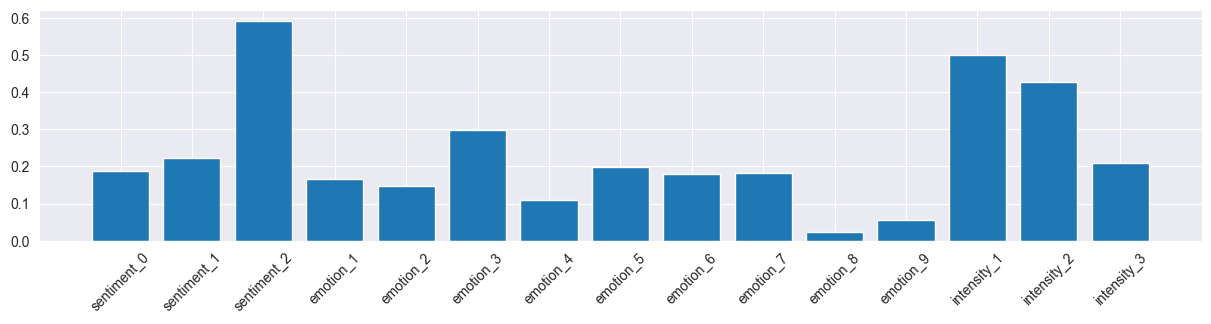

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)
plt.bar(categor_freq.index, categor_freq.values)
_ = plt.xticks(rotation = 45)

Data exploration step: plot abstracts using PCA

In [17]:
multi_label_binarizer_MEISD = pd.read_csv('multi_label_binarizer_MEISD.csv')

In [18]:
multi_label_binarizer_MEISD.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,intensity_1,intensity_2,intensity_3
0,look around you,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,say hello to your competition,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,eight of you will switch to an easier specialty,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,five of you will crack under the pressure,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,two of you will be asked to leave,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juwieczo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [20]:
multi_label_binarizer_MEISD.shape

(20017, 16)

In [21]:
df0 = multi_label_binarizer_MEISD

In [22]:
# To reduce the data size we randomly subsample abstracts with a single category
sample_pca = df0.loc[df0.iloc[:,1:].apply(sum, axis=1) == 1,:].sample(n = 504, random_state = 4)

In [23]:
sample_pca.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,intensity_1,intensity_2,intensity_3
6051,When Dothraki are defeated in combat,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13002,bean-speak for tortoise. okay?,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12514,you guys find a death wound?,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
18345,mystery solved,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6381,See l told Varys that l was giving the Princes...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
X = TfidfVectorizer(stop_words='english').fit_transform(sample_pca.Utterances).todense()

In [24]:
X = TfidfVectorizer(stop_words='english').fit_transform(df0.Utterances).todense()

In [44]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_array = np.asarray(X)
X_scaled = StandardScaler().fit_transform(X_array)

pca = PCA(n_components=2)
data2D = pd.DataFrame(pca.fit_transform(X_scaled), columns=['PC1', 'PC2'])

In [9]:
data2D

,PC1,PC2
0,-0.008059,-0.022402
1,-0.013171,-0.029411
2,-0.014860,-0.023826
3,-0.014355,-0.023160
4,-0.016173,-0.029118
...,...,...
20012,-0.034456,0.005719
20013,-0.015482,-0.035266
20014,-0.014801,-0.024147
20015,-0.015517,-0.023273


In [47]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.00070476, 0.00062573])

In [49]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf')
X_kpca = kpca.fit_transform(X_scaled)


C:\Users\Julix\AppData\Local\Temp\ipykernel_12620\1366849654.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_kpca[:, 0], X_kpca[:, 1], cmap='viridis', s=50, alpha=0.7)


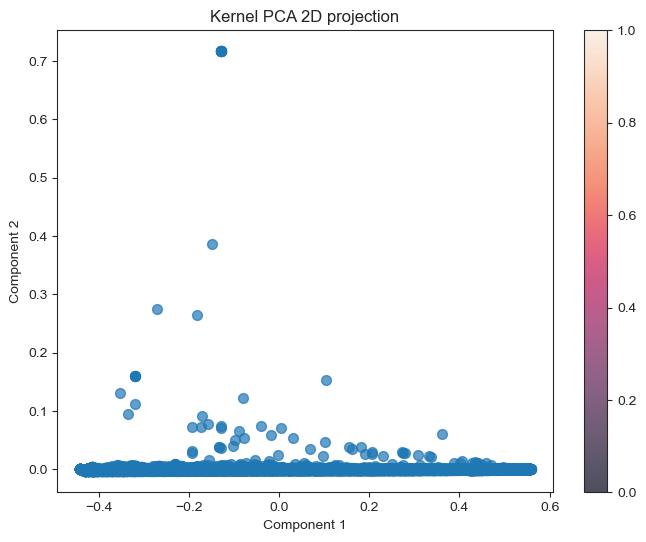

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], cmap='viridis', s=50, alpha=0.7)
plt.colorbar() 
plt.title('Kernel PCA 2D projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [51]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0005)
X_selected = selector.fit_transform(X_array)


C:\Users\Julix\AppData\Local\Temp\ipykernel_12620\2608534423.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], cmap='plasma', s=50, alpha=0.7)


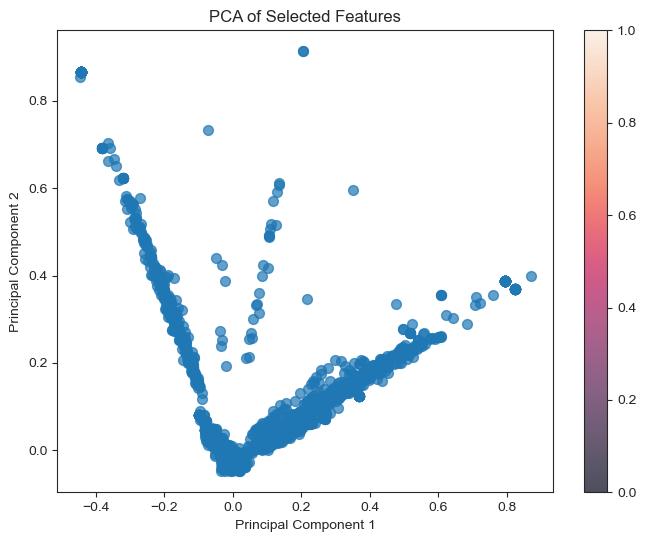

In [53]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], cmap='plasma', s=50, alpha=0.7)
plt.colorbar()
plt.title('PCA of Selected Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


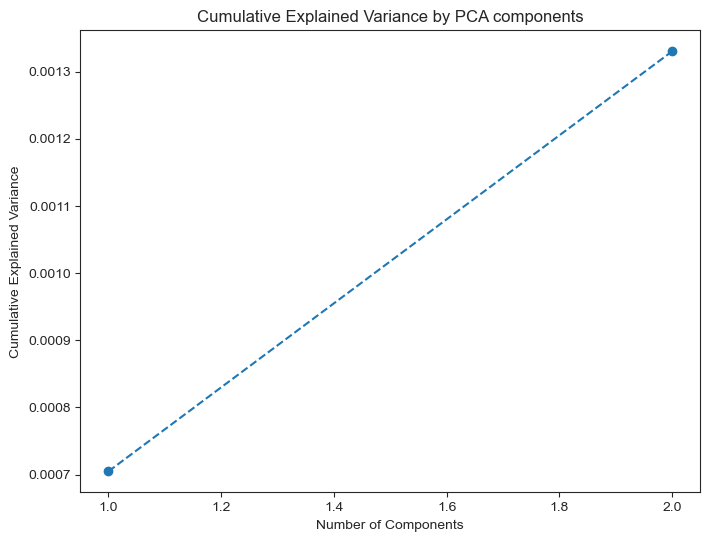

In [46]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [12]:
# Get the corresponding categories for abstracts
color = df0.iloc[:,2:].apply(lambda x: x.index[x>0][0], axis = 1)
data2D['category'] = color.to_list()

In [13]:
data2D

,PC1,PC2,category
0,-0.008059,-0.022402,sentiment_2
1,-0.013171,-0.029411,sentiment_2
2,-0.014860,-0.023826,sentiment_2
3,-0.014355,-0.023160,sentiment_2
4,-0.016173,-0.029118,sentiment_2
...,...,...,...
20012,-0.034456,0.005719,emotion_3
20013,-0.015482,-0.035266,emotion_3
20014,-0.014801,-0.024147,emotion_2
20015,-0.015517,-0.023273,emotion_3


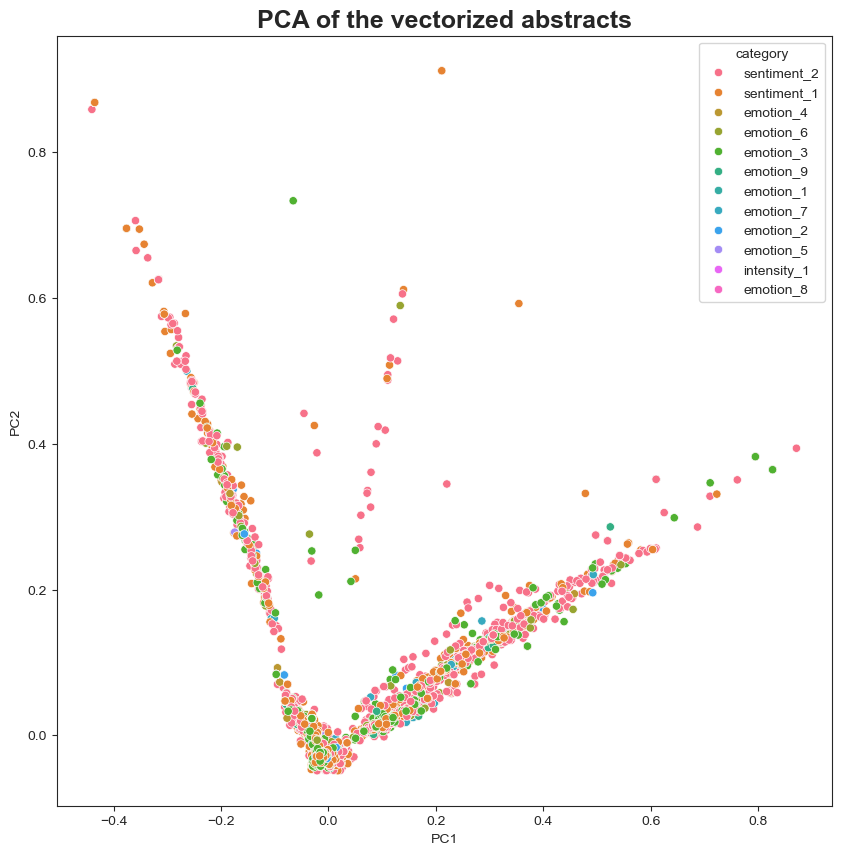

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
sns.set_style("ticks")
_=sns.scatterplot(data=data2D, x='PC1', y='PC2', hue='category') \
    .set_title("PCA of the vectorized abstracts", fontdict= { 'fontsize': 18, 'fontweight':'bold'})

t-SNE

perplexity – domyślnie 30, sugerowane wartości: 5-50.
learning_rate – domyślnie 200, czasami dobrze działa od 10 do 1000.
n_iter – liczba iteracji, domyślnie 1000, ale dla lepszych wyników możesz zwiększyć do 1500-3000.


In [1]:
from sklearn.manifold import TSNE

In [26]:
X_array = np.asarray(X)

In [29]:
print(multi_label_binarizer_MEISD.columns)

Index(['Utterances', 'sentiment_0', 'sentiment_1', 'sentiment_2', 'emotion_1',
       'emotion_2', 'emotion_3', 'emotion_4', 'emotion_5', 'emotion_6',
       'emotion_7', 'emotion_8', 'emotion_9', 'intensity_1', 'intensity_2',
       'intensity_3'],
      dtype='object')


In [30]:
color = df0.iloc[:, 2:].idxmax(axis=1) 

In [31]:
color

0        sentiment_2
1        sentiment_2
2        sentiment_2
3        sentiment_2
4        sentiment_2
            ...     
20012      emotion_3
20013      emotion_3
20014      emotion_2
20015      emotion_3
20016    sentiment_1
Length: 20017, dtype: object

D:\conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


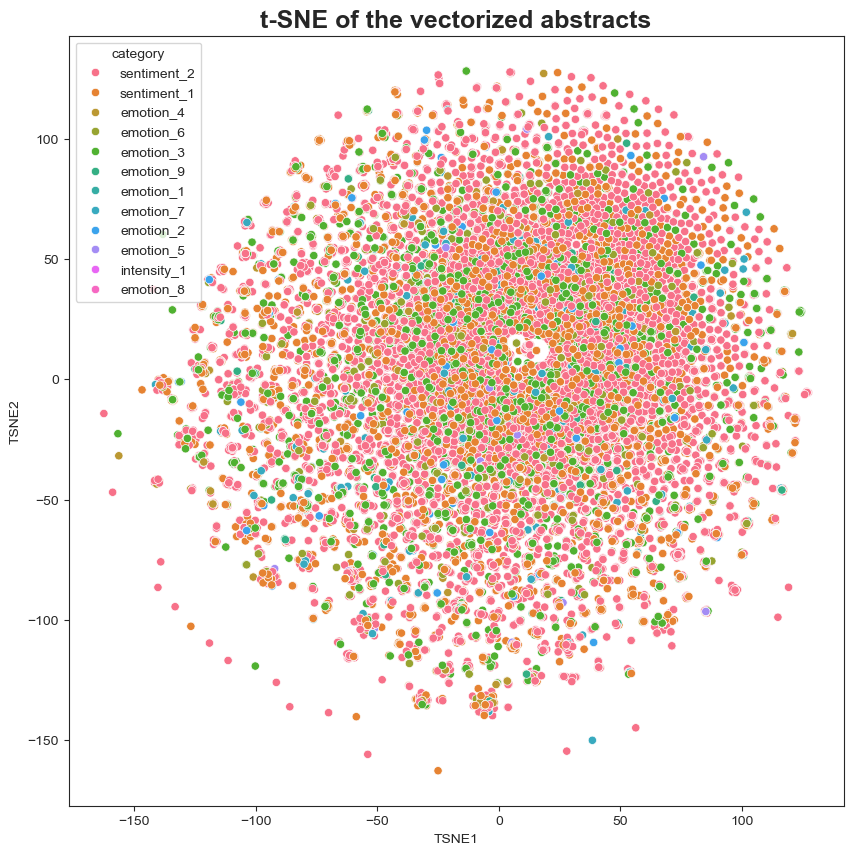

In [43]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=500, n_iter=1500)
data_tsne = pd.DataFrame(tsne.fit_transform(X_array), columns=['TSNE1', 'TSNE2'])

color = df0.iloc[:, 2:].idxmax(axis=1) 
data_tsne['category'] = color

plt.rcParams["figure.figsize"] = (10,10)
sns.set_style("ticks")
sns.scatterplot(data=data_tsne, x='TSNE1', y='TSNE2', hue='category') \
    .set_title("t-SNE of the vectorized abstracts", fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.show()


UMAP
n_neighbors=15: 
                UMAP używa sąsiadów do zachowania lokalnych struktur danych. Możesz eksperymentować z tą wartością, np. zmniejszyć ją do 5 lub zwiększyć do 30, w zależności od wyniku.
n_components=2: 
                Liczba wymiarów do zredukowania, tutaj 2D, aby można było wizualizować.
metric='cosine': 
                Używamy miary kosinusowej, która często działa dobrze w zadaniach związanych z tekstem. Można również przetestować inne miary jak „euclidean”.


D:\conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


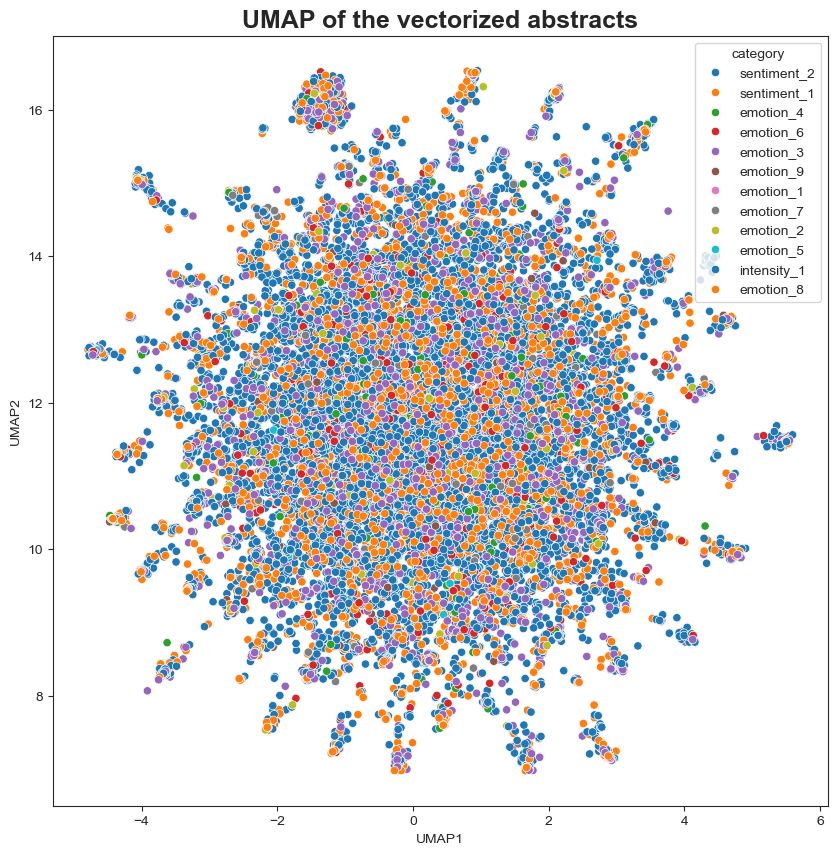

In [41]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)

umap_embedding = umap_model.fit_transform(X_array)

umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])

umap_df['category'] = color.to_list()

plt.figure(figsize=(10, 10))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='category', palette='tab10')
plt.title('UMAP of the vectorized abstracts', fontsize=18, fontweight='bold')
plt.show()


#Spearman corellation

Porównanie metod korelacji

Korelacja Pearsona:
Zastosowanie: Używana do badania liniowych zależności między zmiennymi ilościowymi.
Wymagania: Zakłada, że zmienne mają rozkład normalny i są ilościowe (np. zmienne ciągłe).
Kiedy NIE używać: Dla danych binarnych lub o rozkładzie dalekim od normalnego, ponieważ może dawać zniekształcone wyniki.

Korelacja Spearmana:
Zastosowanie: Mierzy siłę monotonicznej zależności między zmiennymi, niezależnie od tego, czy zależność jest liniowa. Działa na danych rangowych i porządkowych.
Wymagania: Nie wymaga rozkładu normalnego i dobrze radzi sobie z danymi binarnymi i porządkowymi (np. nasilenie emocji, kategorie).
Kiedy używać: Gdy zależności mogą być nieliniowe lub dane są porządkowe, kategoryczne, binarne.

Korelacja Kendalla (tau):
Zastosowanie: Alternatywa dla Spearmana, często stosowana do badania korelacji między zmiennymi porządkowymi. Jest bardziej dokładna w przypadku małych próbek.
Wymagania: Tak jak w Spearmanie, nie wymaga normalności danych, ale może być wolniejsza obliczeniowo.
Kiedy używać: Przy małych próbkach danych porządkowych lub binarnych, gdy potrzebna jest bardzo dokładna miara korelacji.


In [17]:
multi_label_binarizer_MEISD.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,intensity_1,intensity_2,intensity_3
0,look around you,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,say hello to your competition,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,eight of you will switch to an easier specialty,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,five of you will crack under the pressure,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,two of you will be asked to leave,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [18]:
selected_columns = ['sentiment_0', 'sentiment_1', 'sentiment_2','emotion_1','emotion_2', 'emotion_3','emotion_4', 'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8', 'emotion_9']
selected_df = multi_label_binarizer_MEISD[selected_columns]

In [19]:
correlation_matrix = selected_df.corr(method='spearman')
print(correlation_matrix)

             sentiment_0  sentiment_1  sentiment_2  emotion_1  emotion_2  \
sentiment_0     1.000000    -0.255405    -0.576830  -0.213576  -0.148104   
sentiment_1    -0.255405     1.000000    -0.642447  -0.222102   0.381029   
sentiment_2    -0.576830    -0.642447     1.000000   0.356935  -0.204536   
emotion_1      -0.213576    -0.222102     0.356935   1.000000  -0.185936   
emotion_2      -0.148104     0.381029    -0.204536  -0.185936   1.000000   
emotion_3       0.334699    -0.202616    -0.094101  -0.291851  -0.211676   
emotion_4       0.049194     0.113580    -0.134955  -0.156332  -0.101306   
emotion_5      -0.215085     0.550621    -0.294732  -0.221390   0.257702   
emotion_6       0.162560    -0.144775    -0.006530  -0.209578  -0.118141   
emotion_7       0.250208    -0.188854    -0.038759  -0.210003  -0.158813   
emotion_8      -0.068828     0.089999    -0.021484  -0.068967  -0.064390   
emotion_9       0.053914    -0.080277     0.025092  -0.108857  -0.083293   

           

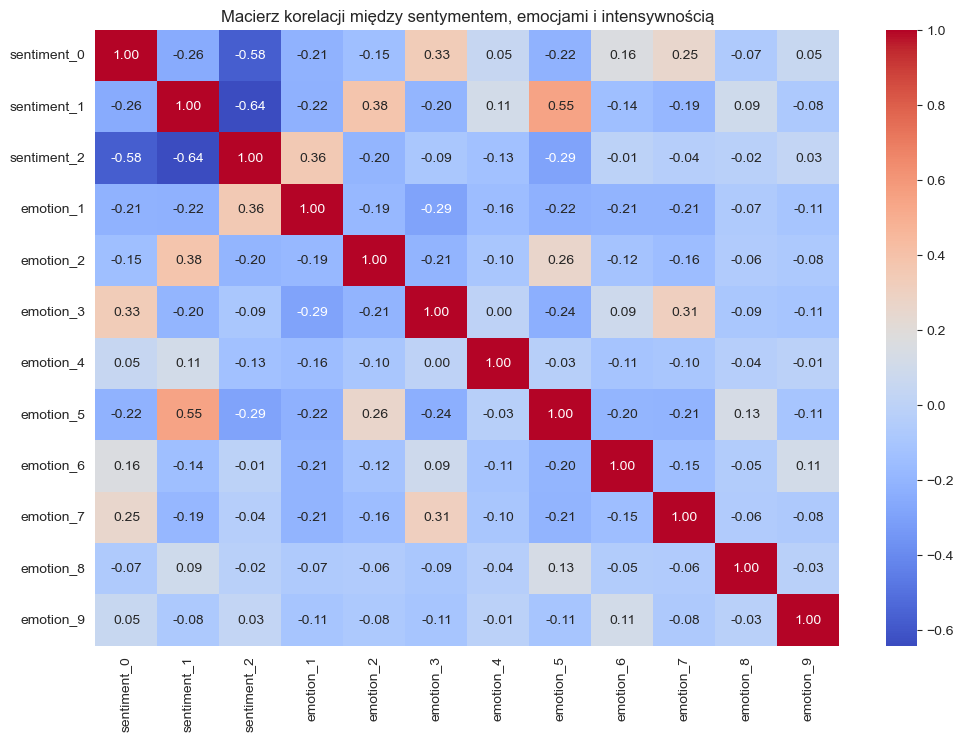

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Macierz korelacji między sentymentem, emocjami')
plt.show()


In [21]:
selected_columns = ['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4', 'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8', 'emotion_9', 'intensity_1', 'intensity_2', 'intensity_3']
selected_df = multi_label_binarizer_MEISD[selected_columns]
correlation_matrix = selected_df.corr(method='spearman')
print(correlation_matrix)

             emotion_1  emotion_2  emotion_3  emotion_4  emotion_5  emotion_6  \
emotion_1     1.000000  -0.185936  -0.291851  -0.156332  -0.221390  -0.209578   
emotion_2    -0.185936   1.000000  -0.211676  -0.101306   0.257702  -0.118141   
emotion_3    -0.291851  -0.211676   1.000000   0.000233  -0.236031   0.085914   
emotion_4    -0.156332  -0.101306   0.000233   1.000000  -0.027244  -0.113759   
emotion_5    -0.221390   0.257702  -0.236031  -0.027244   1.000000  -0.202139   
emotion_6    -0.209578  -0.118141   0.085914  -0.113759  -0.202139   1.000000   
emotion_7    -0.210003  -0.158813   0.312906  -0.100007  -0.206563  -0.148672   
emotion_8    -0.068967  -0.064390  -0.094352  -0.035964   0.132491  -0.052614   
emotion_9    -0.108857  -0.083293  -0.107501  -0.013527  -0.106029   0.112171   
intensity_1  -0.445444   0.101432   0.296405   0.040857   0.110592   0.196004   
intensity_2  -0.385238   0.099177   0.227577   0.142921   0.084393   0.164967   
intensity_3  -0.143261   0.0

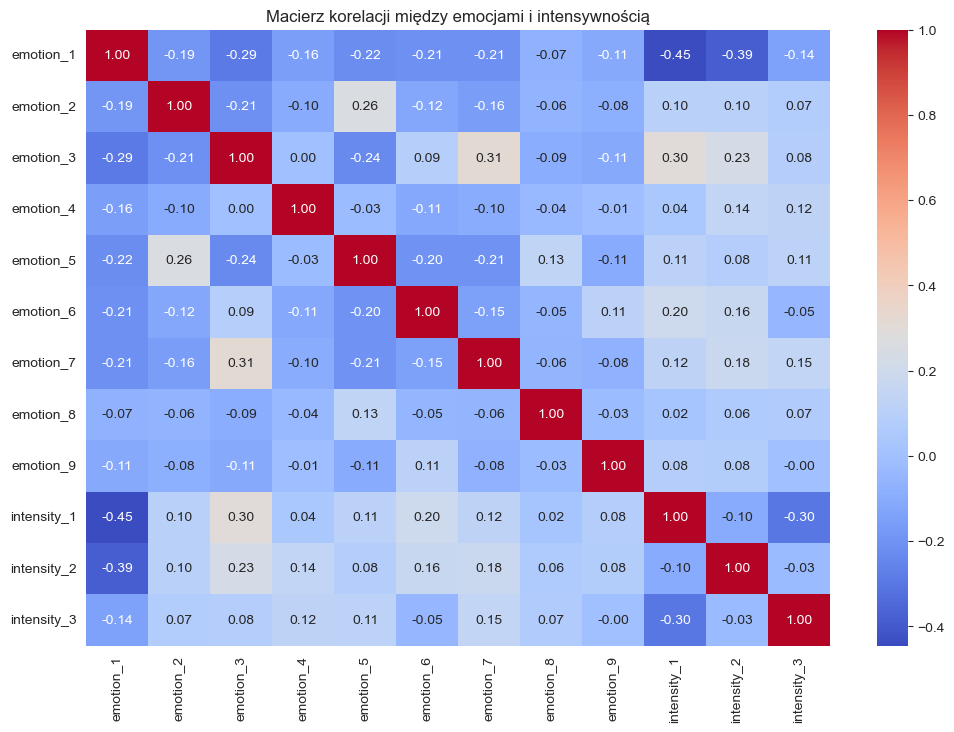

In [27]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Macierz korelacji między emocjami i intensywnością')
plt.show()


In [29]:
multi_label_binarizer_MEISD.shape

(20017, 16)